# <center> Module 3a - IP Networks Overview 
## <center> SYSE 549: Secure Vehicle and Industrial Networking
## <center> <img src="https://www.engr.colostate.edu/~jdaily/Systems-EN-CSU-1-C357.svg" width="400" /> 
### <center> Instructor: Dr. Jeremy Daily<br>Orignal version written by Jerry Duggan

## Learning Objectives
By the end of this lesson, students should be able to:
1. Demonstrate socket connections.
2. Summarize the steps required to establish communication between a server and client.
3. Understand the requirements for a socket connection.

Additional learning objectives are included in subsequent notebooks.

## Basic transport control protocol (TCP) socket communication (connection-oriented)

The first program we are going to walk through shows how to communicate between a client and a server using TCP (connection-oriented) sockets.  To run the example, open the notebooks [Basic Client](./03c%20Basic%20Client.ipynb) and [Basic Server](./03b%20Basic%20Server.ipynb) in separate windows.  I recommend that you arrange your browser so you can see both notebooks on your screen simultaneously.  Then start with Step 1 - Server setup in the Basic Server notebook.

The client and the server run in separate processes (and, in fact, in most cases will be running on separate computers).  This means that many of the operations on both sides can happen asynchronously.  There are, however, points where the processes must be synchronized.  The operating system provides this synchronization by blocking the process waiting for the event (connection setup, I/O, etc.).  As a helpful roadmap, the steps of both the BasicClient are shown below, with green lines showing points of synchronization.

![BasicClientServer.png](images/BasicClientServer.png)

## Specifying the IP Address in a Server Application
When you write a server application that uses sockets, one of the first steps is to bind the socket to an IP address and a port. By choosing either INADDR_ANY or INADDR_LOOPBACK, you control which network interfaces are used. Here’s why the specific IP address matters and the difference between some common choices
### INADDR_ANY
When you bind your server socket to INADDR_ANY (typically represented as 0.0.0.0), you tell the operating system to accept connections on any of the host’s network interfaces.


This is useful when your machine has more than one network adapter (for instance, Ethernet, Wi-Fi, etc.) and you want your server to listen for incoming connections regardless of which physical or virtual network adapter the connection arrives on.

### INADDR_LOOPBACK
When you bind the server to INADDR_LOOPBACK (commonly 127.0.0.1), the socket is restricted to the loopback interface. This means that only processes running on the same macine can connect to the server.

This is often used for testing, debugging, or services that should not be accessible from external networks. If you bind with INADDR_LOOPBACK, you intentionally limit connections to local processes.

### Why Specify the IP Address?

On machines with multiple network adapters, each adapter might have its own IP address. By specifying a particular IP address, you ensure that the server binds to the desired adapter. This is useful for machines that should have separate handling for public vs. private traffic or when configuring services to run on specific networks.

For further details on how IP addressing works and the roles of these constants, you may refer to the [ip man page](https://man7.org/linux/man-pages/man7/ip.7.html).

### Running Client/Server Steps Out of Sequence

In a properly functioning client/server setup, the server is expected to start, bind its socket, and listen for incoming connections before the client attempts to connect. Changing this order or misconfiguring some steps can lead to specific error conditions:

ECONNREFUSED: If the client tries to connect to the server before the server has started listening on the designated port, the connection attempt will be actively refused. The error tells you that there is no service currently listening at that address and port combination.

EADDRNOTAVAIL: This error can occur if you try to bind a socket to an IP address that is not configured on the host. The system does not recognize that IP as being available; typically, this happens when you inadvertently specify an IP that isn’t associated with any of the machine’s network adapters.

ENETUNREACH: This error appears when a network route to the destination is unavailable—possibly due to misconfiguration or attempting to use an IP that is only reachable through a network path that isn’t active. It essentially indicates that the network is unreachable from the current host context.

EADDRINUSE: This error occurs during the binding process if the chosen IP address and port combination is already in use by another application or an earlier instance of the server that did not exit cleanly. The address (or port) is occupied. This is a signal to either choose a different port or ensure that the previous binding has been properly closed before attempting to bind again.

Sequential steps ensure proper initialization. Each system call (bind, listen, connect) depends on the successful completion of previous steps. Running the steps out of order, or specifying the wrong IP address, disrupts these dependencies, leading to errors that help pinpoint the issue.

For more detailed system call error definitions, you can check the respective man pages:

[connect(2)](https://man7.org/linux/man-pages/man2/connect.2.html) for connection errors (ECONNREFUSED, EADDRNOTAVAIL, ENETUNREACH) 

[bind(2)](https://man7.org/linux/man-pages/man2/bind.2.html) for binding errors (EADDRINUSE) 


# UDP sockets (datagram-oriented)

The second program we are going to look at uses UDP datagram-oriented sockets for communication.  To run this example, open the notebooks [UDPClient](./02e%20UDPClient.ipynb) and [UDPServer](./02f%20UDPServer.ipynb) in separate windows.  Again, I recommend that you have both notebooks opened side-by-side.

Here is a sequence diagram for the UDP socket communication.

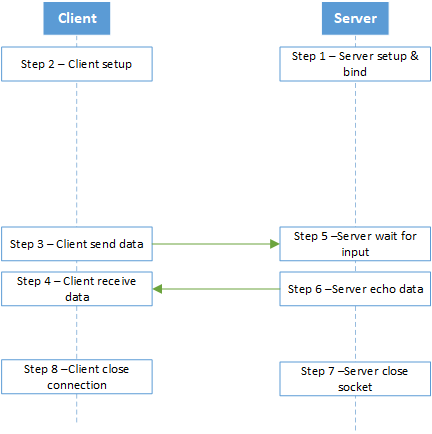

### Ending Communications

TCP’s FIN Packet: When a client signals it’s done sending (via shutdown or close), its TCP stack sends a FIN packet to the server.

Detecting EOF: The server’s subsequent read from the socket returns 0, indicating that no more data will be sent.

Application-Level Protocols: Many protocols add their own end-of-message indicators on top of TCP’s mechanisms to define clear message boundaries.

UDP Considerations: In contrast, connectionless protocols like UDP require additional protocol-specific methods to indicate the end of transmission.

### Security Considerations
When a connection is terminated, various security vulnerabilities can arise, including:

* TCP RST Injection: Unauthorized injection of reset packets to force disconnection.

* Resource Exhaustion: Mismanagement of connection termination leading to excessive TIME_WAIT states and resource depletion.

* Incomplete Data Transmission: Abrupt closures that result in data truncation, which may impact the integrity of transmitted data.

* Race Conditions: Timing issues during connection shutdown that can be exploited for injection or replay attacks.

* Secure Protocol Vulnerabilities: In protocols like TLS, failure to execute a proper shutdown handshake (e.g., missing close_notify) can lead to vulnerabilities such as truncation attacks.

### Guaranteed Behaviors
* What are the guaranteed behaviors for SOCK_STREAM vs. SOCK_DGRAM sockets?
    * SOCK_STREAM -- packet order, no duplicates, timeouts, retransmission
        * At the application level, you cannot make assumptions that you will get *all* requested data on a read().  You will have to keep track of this!
        * Similar for sending data -- the OS level interface to sockets is not guaranteed to send all the data provided in the buffer at every call -- it returns the number of bytes actually written to the network.  You would have to keep track of this, or use the Python sockets call 'socket.sendall' which takes care of this for you.
    * SOCK_DGRAM -- None, really...  If you care, you will have to write your own.  Or use a SOCK_STREAM socket.
        * The application is guaranteed to get all the data sent...  If it gets it at all.
    * For most real-world applications, neither of these Quality of Service guarantees are sufficient for robust communications.  You will typically need to implement some level 7 (Application Layer) behaviors

# Wireshark

Wireshark is an incredibly useful tool for examining network traffic.  I have provided a walkthrough on how to install wireshark and some basic pointers on how to get it running.  I have also used it on both the TCP and UDP socket examples.  To run the walkthrough, open the [Wireshark](./02d%20Wireshark.ipynb) notebook.

Food for thought:
* Why is are there no Wireshark traces when either the client or the server closes the connection or socket?
* Whenever I look at a complete traffic dump off of my system from Wireshark, I am amazed at the amount of network traffic.  It is kinda scary.  It is even more scary when you think of the amount of traffic that is routed to endpoints outside of the local network.

# Multiple client connections

The examples shown above illustrate a single client connecting to the servers.  This is not the case in the real world -- typical servers need to be able to handle many client connections.  I have provided some examples of how to write your servers to manage multiple connections.

There are two considerations the server must address to handle multiple simultaneous client connections:
1. The server must keep track of which client is sending data.  At the very least, the server will use this to send any reply data (if any).  Other reasons for the server to identify which client sends data include maintaining security contexts, "shopping carts", and similar context related information.
1. As we have seen, some system calls (such as accept() and recv()) block, waiting for data from the client.  While the server is blocked on these calls, other clients might need data from other steps in the process.

The examples in the notebooks are set up to show the steps to establish & perform communication on gory detail.  In order to do this, they are written in a style that is not conducive to good software engineering practices.  The notebooks in this section use a more maintainable software style.

It is also rather cumbersome to have multiple client notebooks up at the same time.  To address this, you will need to start a Python CLI, 'cd' to this directory, and run clients from the CLI.  To illustrate multiple clients, you will have to start at least two Python CLI windows, one for each client.

The following notebooks illustrate scenarios for handling multiple client connections:
* [UDPMultiServer](./03h%20UDPMultiServer%20Instructions.ipynb) shows how to handle multiple client connections using UDP sockets;
* [TCPMultiServer](./03g%20TCPMultiServer%20Instructions.ipynb) shows how to handle multiple client connections using TCP sockets.

Food for thought:
* Both the UDPMultiServer and TCPMultiServer programs were designed for simplicity and to illustrate their specific points.  This means they are ignoring other software implementation considerations for "application hygene".  What are some of these considerations, and how could they be addressed?